In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-08T12:39:59.321642+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

seaborn   : 0.11.1
matplotlib: 3.3.4
pandas    : 0.25.3
numpy     : 1.20.3
sklearn   : 0.24.2



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

## Load data

In [8]:
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
    cat_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
    num_cols = pkl.load(pickle_file)

In [9]:
x_train.shape, x_val.shape, df_test.shape, len(cat_cols), len(num_cols)

((5589, 978), (1398, 978), (3000, 974), 0, 942)

In [10]:
cat_cols = cat_cols + ['category']
print(cat_cols)

['category']


отделяем метки от данных

In [11]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5589, 975), (1398, 975), (5589, 3), (1398, 3))

In [12]:
x_train.shape

(5589, 975)

In [13]:
#cat_cols + num_cols


In [14]:
#views
train_ds_views = Pool(x_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      y_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

val_ds_views   = Pool(x_val[cat_cols + num_cols],
#val_ds_views   = Pool(x_val[cat_cols + ['ctr']],
                      y_val[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )


#depth
train_ds_depth = Pool(x_train[cat_cols + num_cols],
                      y_train[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_depth   = Pool(x_val[cat_cols + num_cols],
                      y_val[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )


#full_reads_percent
#у frp корреляция с depth. так что добавим признак deprh_pred и соберем датасет уже после предсказания depth

In [15]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [16]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [17]:
cb_model_views = CatBoostRegressor(iterations=20,
                                 learning_rate=0.1,
                                 depth=4,
                                 random_seed = CB_RANDOMSEED,
                   #n_estimators=100,
                                  )
# Fit model
cb_model_views.fit(train_ds_views,
        #train_data, train_labels,
                   eval_set=val_ds_views, 
                   #plot = True,
                  )

0:	learn: 101652.1475836	test: 51223.4943165	best: 51223.4943165 (0)	total: 256ms	remaining: 4.86s
1:	learn: 97973.9181502	test: 50426.3027018	best: 50426.3027018 (1)	total: 301ms	remaining: 2.71s
2:	learn: 95581.1395976	test: 48300.9650622	best: 48300.9650622 (2)	total: 342ms	remaining: 1.94s
3:	learn: 92872.0084461	test: 46439.4626267	best: 46439.4626267 (3)	total: 382ms	remaining: 1.53s
4:	learn: 90337.4954425	test: 45453.1344099	best: 45453.1344099 (4)	total: 422ms	remaining: 1.26s
5:	learn: 87581.9518433	test: 44907.9675540	best: 44907.9675540 (5)	total: 463ms	remaining: 1.08s
6:	learn: 86278.9384742	test: 44448.9520131	best: 44448.9520131 (6)	total: 506ms	remaining: 939ms
7:	learn: 84623.7142422	test: 43306.6044943	best: 43306.6044943 (7)	total: 545ms	remaining: 818ms
8:	learn: 83263.3353478	test: 43153.5850198	best: 43153.5850198 (8)	total: 588ms	remaining: 718ms
9:	learn: 81462.8115055	test: 42797.6271742	best: 42797.6271742 (9)	total: 628ms	remaining: 628ms
10:	learn: 80200.97

In [18]:
# Get predictions and metrics
preds_train_views = cb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = cb_model_views.predict(val_ds_views)

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.526447737099264, 0.3903379002036568)

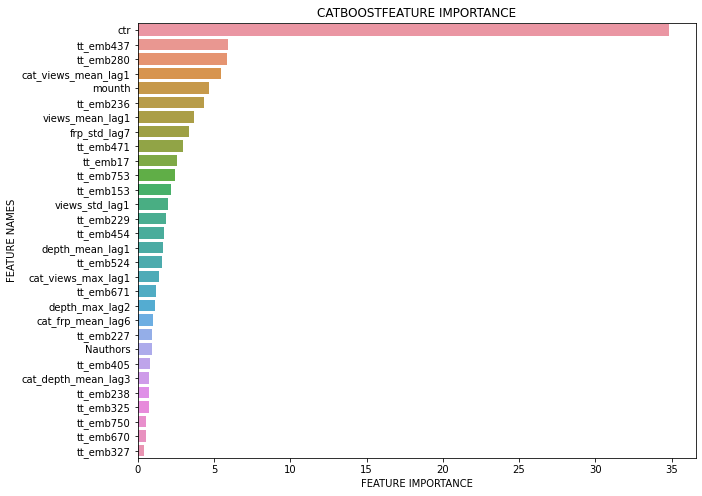

In [19]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_views.get_feature_importance(), train_ds_views.get_feature_names(), 'CATBOOST')

## depth

In [20]:
cb_model_depth = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                  )
# Fit model
cb_model_depth.fit(train_ds_depth,
                   eval_set=val_ds_depth, 
                   #plot = True,
                  )

0:	learn: 0.0644520	test: 0.0581930	best: 0.0581930 (0)	total: 2.13s	remaining: 3m 30s
1:	learn: 0.0627291	test: 0.0564978	best: 0.0564978 (1)	total: 4.39s	remaining: 3m 34s
2:	learn: 0.0611382	test: 0.0548615	best: 0.0548615 (2)	total: 6.65s	remaining: 3m 34s
3:	learn: 0.0594831	test: 0.0532627	best: 0.0532627 (3)	total: 8.94s	remaining: 3m 34s
4:	learn: 0.0580289	test: 0.0517268	best: 0.0517268 (4)	total: 11.2s	remaining: 3m 32s
5:	learn: 0.0566333	test: 0.0502771	best: 0.0502771 (5)	total: 13.4s	remaining: 3m 30s
6:	learn: 0.0553124	test: 0.0488564	best: 0.0488564 (6)	total: 15.6s	remaining: 3m 27s
7:	learn: 0.0540254	test: 0.0475802	best: 0.0475802 (7)	total: 17.9s	remaining: 3m 25s
8:	learn: 0.0527934	test: 0.0464910	best: 0.0464910 (8)	total: 20.2s	remaining: 3m 23s
9:	learn: 0.0517026	test: 0.0455100	best: 0.0455100 (9)	total: 22.4s	remaining: 3m 21s
10:	learn: 0.0506645	test: 0.0445090	best: 0.0445090 (10)	total: 24.6s	remaining: 3m 19s
11:	learn: 0.0496161	test: 0.0435540	best

In [21]:
# Get predictions and metrics
preds_train_depth = cb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = cb_model_depth.predict(val_ds_depth)

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.8397164101577229, 0.747948360540658)

In [22]:
x_train.shape

(5589, 975)

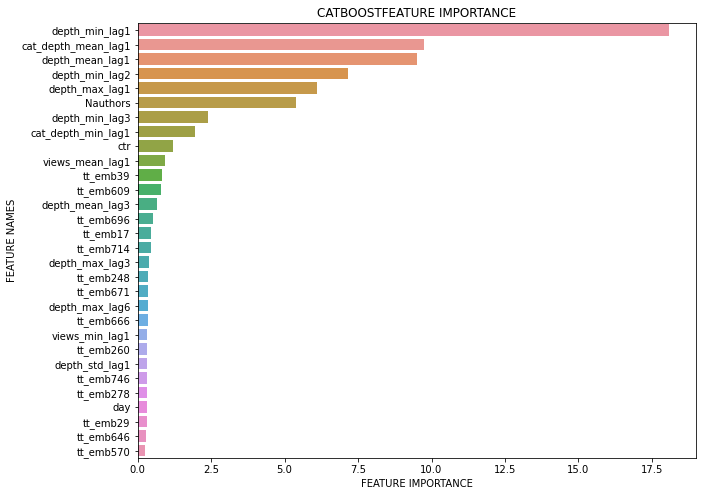

In [23]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_depth.get_feature_importance(), train_ds_depth.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [24]:
#pd.DataFrame(preds_train_depth, columns = ['depth_pred'])
pred_scaler = preprocessing.StandardScaler()
tmp = pred_scaler.fit_transform(preds_train_depth.reshape(-1, 1))
pred_depth_train = pd.DataFrame(tmp, columns = ['depth_pred'])

pred_depth_val   = pd.DataFrame(pred_scaler.transform(preds_val_depth.reshape(-1, 1)), columns = ['depth_pred'])

In [25]:
print('before ', x_train.shape, x_val.shape, preds_train_depth.shape, preds_val_depth.shape)
x_train = pd.concat([x_train, pred_depth_train], axis = 1)
x_val   = pd.concat([x_val,   pred_depth_val],   axis = 1)
print('after  ', x_train.shape, x_val.shape)

before  (5589, 975) (1398, 975) (5589,) (1398,)
after   (6704, 976) (2541, 976)


In [26]:
train_ds_frp = Pool(x_train[cat_cols + num_cols + ['depth_pred']],
                      y_train[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols + ['depth_pred'],
                     )

val_ds_frp   = Pool(x_val[cat_cols + num_cols + ['depth_pred']],
                      y_val[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols + ['depth_pred'],
                     )

CatBoostError: Length of label=5589 and length of data=6704 is different.

In [ ]:
cb_model_frp = CatBoostRegressor(#iterations=1000,
                                 learning_rate=0.05,
                                 depth=10,
                                 random_seed = CB_RANDOMSEED,
                   n_estimators=100,
                                 #n_estimators=100,
    #num_trees=None,
                                )
# Fit model
cb_model_frp.fit(train_ds_frp,
                   eval_set=val_ds_frp, 
                   #plot = True,
                  )

In [ ]:
# Get predictions and metrics
preds_train_frp = cb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp   = cb_model_frp.predict(val_ds_frp)

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

In [26]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_frp.get_feature_importance(), train_ds_frp.get_feature_names(), 'CATBOOST')

NameError: name 'cb_model_frp' is not defined

In [26]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.6574691326113156, 0.47947194887639855)

In [27]:
NTRY = 6

## save models

In [28]:
cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_1_cb_views.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NTRY}_1_cb_depth.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NTRY}_1_cb_frp.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [33]:
pred_views = cb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = cb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = cb_model_frp.predict(  df_test[cat_cols + num_cols])

In [34]:
subm = pd.DataFrame()
subm['document_id'] = df_test.index

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [35]:
subm.head()

,document_id,views,depth,full_reads_percent
0,0,20078.706076,1.165812,38.174704
1,1,14811.683772,1.058684,30.163389
2,2,14346.062089,1.059364,29.007280
3,3,14178.628973,1.059176,36.559478
4,4,241883.958788,1.159283,31.517749


In [37]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NTRY}_1_cb_ttls_emd_lags_dp.csv'), index = False)